# Setting up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import jieba
import string
import emoji
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from indoNLP.preprocessing import replace_slang
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from snowballstemmer import stemmer

# Dataset

## Original

### Train Dataset

In [2]:
import os
for dirname, _, filenames in os.walk('kaggle/input/multilingual-hatespeech-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/multilingual-hatespeech-dataset/.DS_Store
kaggle/input/multilingual-hatespeech-dataset/Dataset/.DS_Store
kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/zh_hate_translations.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/id_test_translations.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/zh_nonhate_translations.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/id_nonhate_translations.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/id_hate_translations.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/zh_test_translations.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/.DS_Store
kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test1/English_test.csv
kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test1/Porto_test.csv
kaggle/input/multilingual

In [3]:
# load dataset
# train_path = "/content/Dataset/Training/MultiLanguageTrainDataset.csv"
train_path = "kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv"
print('==> Loading the dataset...')
hate_S = pd.read_csv(train_path, na_values = ['unknown', ' '], index_col=0)
print('Load successfully!!\n')
hate_S

==> Loading the dataset...
Load successfully!!



,text,label,language
0,لك من جهة ان شاء بضل حرقة بقلبك وبلاطه ع صدرك ...,0.0,1
1,انجاز جديد للعهدجبران باسيل,0.0,1
2,قلبه كبير وئام وديموقراطي عكس باسيل هههه,0.0,1
3,ولك العما بقلبك عمي يا اوطى مخلوق عوج الارض رو...,1.0,1
4,يسعد صباحك يا قائد,0.0,1
...,...,...,...
219976,USER potong gaji dan fasilitas DPR aja yg 500a...,0.0,13
219977,"Kalian boleh tanya padaku ""kapan rabi?"", tapi ...",0.0,13
219978,Satu persatu akhirnya smua ditumbangkan oleh T...,0.0,13
219979,"USER + itu ga pernah solat, ga pernah ngaji, g...",0.0,13


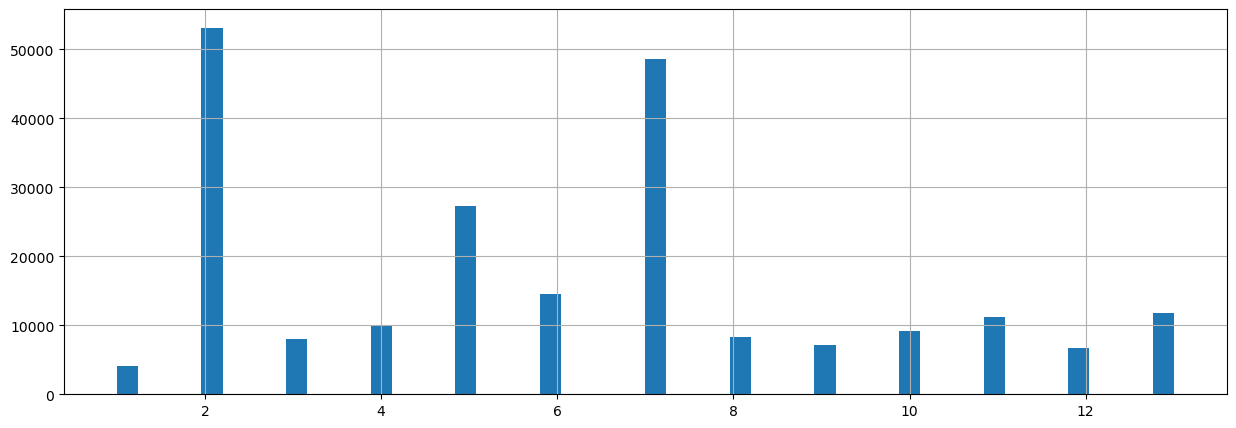

In [4]:
hate_S.language.hist(bins = 50, figsize = (15, 5))
plt.show()

Choose the languages for training

In [5]:
# 1: Arabic
# 4: French
# 5: German
# 6: Russian
# 7: Turkish
# 8: Roman Hindi/ Urdu
# 9: Korean
# 10: Italian
# 11: Spanish
# 12: Portuguese

lang_list = [1, 4, 5, 6, 7, 8, 9, 10, 11, 12]
hate_S.drop(hate_S[hate_S.language.isin(lang_list)].index, axis=0, inplace=True)
hate_S.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73064 entries, 4161 to 219980
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      73064 non-null  object 
 1   label     73064 non-null  float64
 2   language  73064 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


### Validation Dataset

In [6]:
def split_validation(dataframe):
    en_df = dataframe[dataframe.language==2]
    zh_df = dataframe[dataframe.language==3]
    id_df = dataframe[dataframe.language==13]
    
    #Split 30% for every language
    en_train_df, en_val_df = train_test_split(en_df, test_size=0.3, random_state=42)
    zh_train_df, zh_val_df = train_test_split(zh_df, test_size=0.3, random_state=42)
    id_train_df, id_val_df = train_test_split(id_df, test_size=0.3, random_state=42)
    
    # Combine
    train_df = pd.concat([en_train_df, zh_train_df, id_train_df])
    val_df = pd.concat([en_val_df, zh_val_df, id_val_df])
    
    return train_df, val_df

In [7]:
trainset, val_set = split_validation(hate_S)

In [8]:
print(f"Total data points: {len(hate_S)}")
print(f"Training set size: {len(trainset)} ({len(trainset)/len(hate_S)*100:.2f}%)")
print(f"Validation set size: {len(val_set)} ({len(val_set)/len(hate_S)*100:.2f}%)")

Total data points: 73064
Training set size: 51144 (70.00%)
Validation set size: 21920 (30.00%)


language  label
2         0.0      0.539057
          1.0      0.460943
3         0.0      0.652320
          1.0      0.347680
13        0.0      0.613790
          1.0      0.386210
dtype: float64

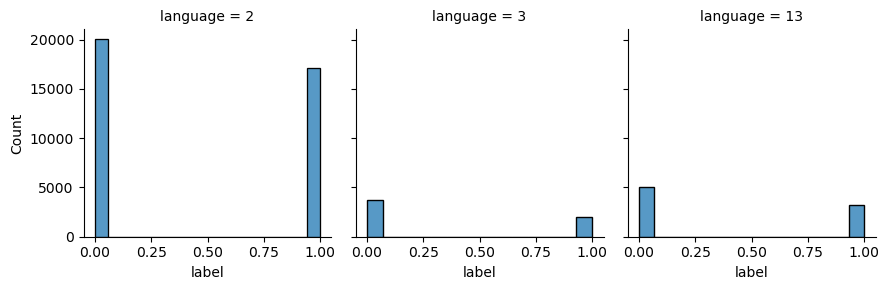

In [9]:
g = sns.FacetGrid(trainset, col="language")
g.map_dataframe(sns.histplot, x="label")

trainset.groupby(['language','label']).size()/trainset.groupby(['language']).size()

language  label
2         0.0      0.543527
          1.0      0.456473
3         0.0      0.661157
          1.0      0.338843
13        0.0      0.624578
          1.0      0.375422
dtype: float64

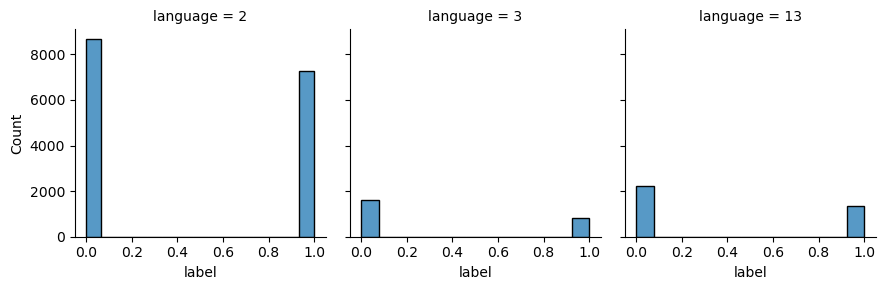

In [10]:
g = sns.FacetGrid(val_set, col="language")
g.map_dataframe(sns.histplot, x="label")

val_set.groupby(['language','label']).size()/val_set.groupby(['language']).size()

## Back Translation

### Train Dataset

In [11]:
hate_bt_id=pd.read_csv('kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/id_hate_translations.csv', index_col=0)
hate_bt_zh=pd.read_csv('kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/zh_hate_translations.csv', index_col=0)

In [12]:
hate_bt_id['text']=hate_bt_id['back_translated_text']
hate_bt_id=hate_bt_id.drop(columns=['translated_text','back_translated_text'])

hate_bt_zh['text']=hate_bt_zh['back_translated_text']
hate_bt_zh=hate_bt_zh.drop(columns=['translated_text','back_translated_text'])

hate_bt=pd.concat([hate_bt_id, hate_bt_zh], axis=0)

### Validation Dataset

In [13]:
def split_validation_bt(bt_df, trainset, val_set):
    
    bt_df_train=bt_df[bt_df.index.isin(trainset.index)]

    
    # Combine
    train_df = pd.concat([trainset, bt_df_train], ignore_index=True, axis=0)
    print(len(trainset), len(bt_df_train))
        
    return train_df, val_set

In [14]:
trainset, val_set = split_validation_bt(hate_bt, trainset, val_set)

51144 5167


In [15]:
# print(f"Total data points: {len(hate_S)+len(hate_bt)}")
# print(f"Training set size: {len(trainset)} ({len(trainset)/(len(hate_S)+len(hate_bt))*100:.2f}%)")
# print(f"Validation set size: {len(val_set)} ({len(val_set)/(len(hate_S)+len(hate_bt))*100:.2f}%)")

Total data points: 80386
Training set size: 56311 (70.05%)
Validation set size: 21920 (27.27%)


language  label
2         0.0      0.539057
          1.0      0.460943
3         0.0      0.484032
          1.0      0.515968
13        0.0      0.442783
          1.0      0.557217
dtype: float64

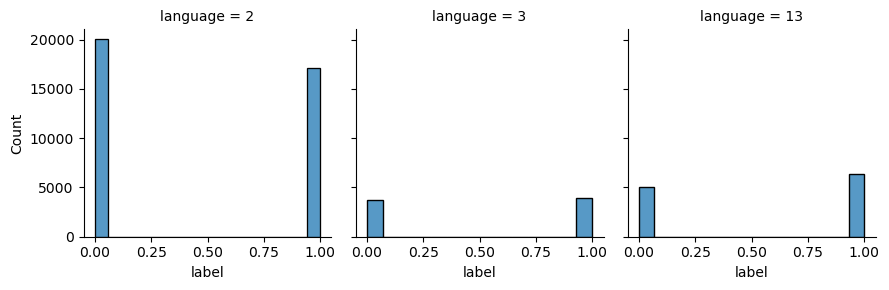

In [16]:
g = sns.FacetGrid(trainset, col="language")
g.map_dataframe(sns.histplot, x="label")

trainset.groupby(['language','label']).size()/trainset.groupby(['language']).size()

language  label
2         0.0      0.543527
          1.0      0.456473
3         0.0      0.661157
          1.0      0.338843
13        0.0      0.624578
          1.0      0.375422
dtype: float64

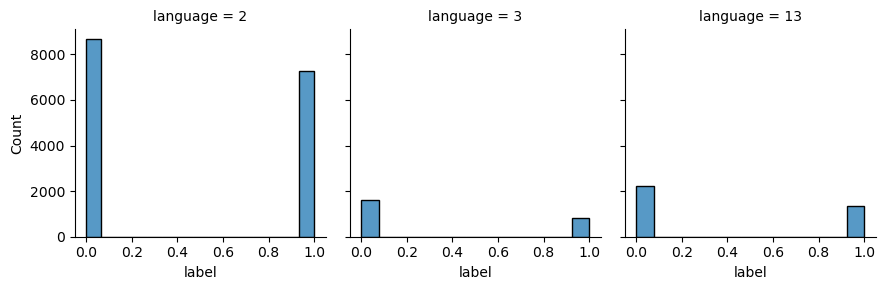

In [17]:
g = sns.FacetGrid(val_set, col="language")
g.map_dataframe(sns.histplot, x="label")

val_set.groupby(['language','label']).size()/val_set.groupby(['language']).size()

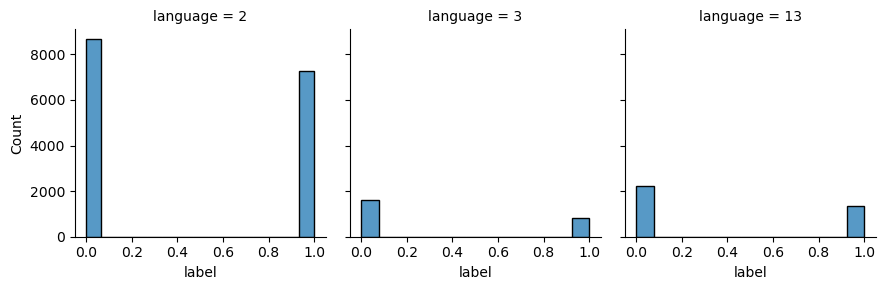

In [18]:
g = sns.FacetGrid(val_set, col="language")
g.map_dataframe(sns.histplot, x="label")

## Test Dataset

In [19]:
# Test
# english_path = "/content/Dataset/Testing/Test1/English_test.csv"
english_path = "kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test1/English_test.csv"
english_test = pd.read_csv(english_path, na_values = ['unknown', ' '], index_col=0)
english_test['language'] = 2   # add one more language column to specify the language

# chinese_path = "/content/Dataset/Testing/Test1/Chinese_test.csv"
chinese_path = "kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test1/Chinese_test.csv"
chinese_test = pd.read_csv(chinese_path, na_values = ['unknown', ' '], index_col=0)
chinese_test['language'] = 3

# indonesian_path = "/content/Dataset/Testing/Test1/Indonesian_test.csv"
indonesian_path = "kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test1/Indonesian_test.csv"
indonesian_test = pd.read_csv(indonesian_path, na_values = ['unknown', ' '], index_col=0)
indonesian_test['language'] = 13

print(english_test.shape)
print(chinese_test.shape)
print(indonesian_test.shape)

(5906, 3)
(897, 3)
(1317, 3)


In [20]:
testset = pd.concat([english_test, chinese_test, indonesian_test])
testset.shape

(8120, 3)

# Dataset Overview

In [21]:
# Info of trainset
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56311 entries, 0 to 56310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      56311 non-null  object 
 1   label     56311 non-null  float64
 2   language  56311 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


In [22]:
# Info of val_set
val_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21920 entries, 9627 to 216134
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      21920 non-null  object 
 1   label     21920 non-null  float64
 2   language  21920 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 685.0+ KB


In [23]:
# Info of testset
testset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8120 entries, 141059 to 242896
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      8120 non-null   object 
 1   label     8120 non-null   float64
 2   language  8120 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 253.8+ KB


## Overview on language

### Trainset

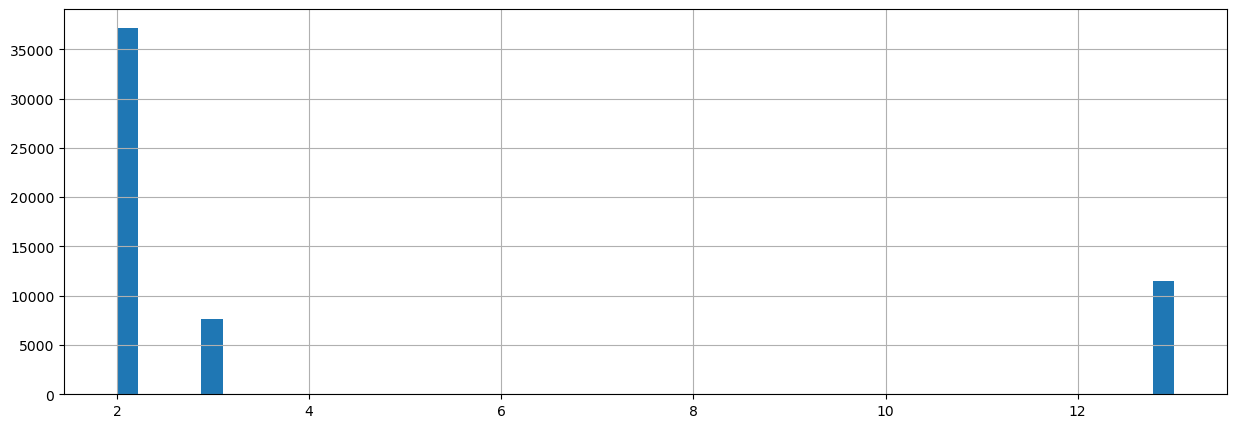

In [24]:
trainset.language.hist(bins = 50, figsize = (15, 5))
plt.show()

In [25]:
value_counts = trainset['language'].value_counts()
print(value_counts)

language
2     37202
13    11500
3      7609
Name: count, dtype: int64


### Validation Set

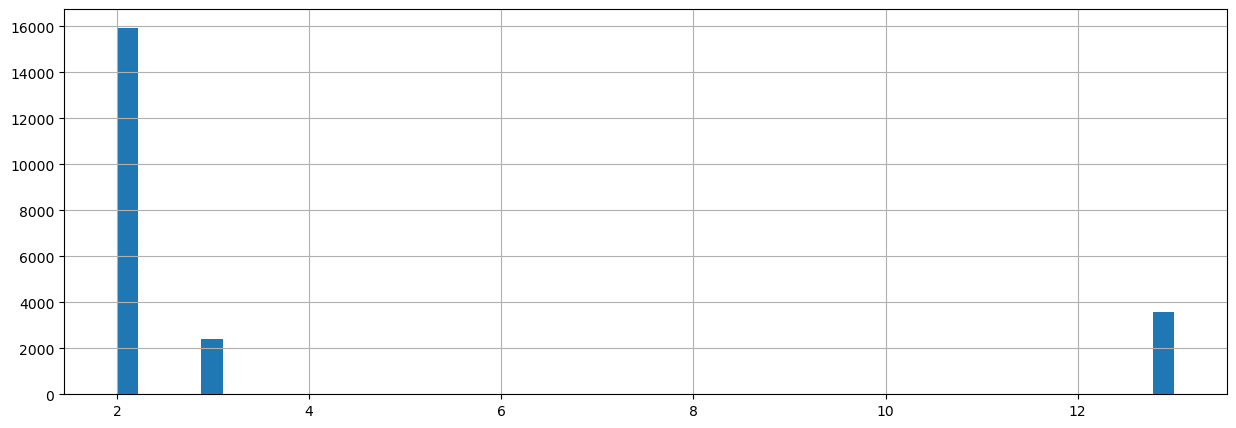

In [26]:
val_set.language.hist(bins = 50, figsize = (15, 5))
plt.show()

In [27]:
value_counts = val_set['language'].value_counts()
print(value_counts)

language
2     15944
13     3556
3      2420
Name: count, dtype: int64


### Testset

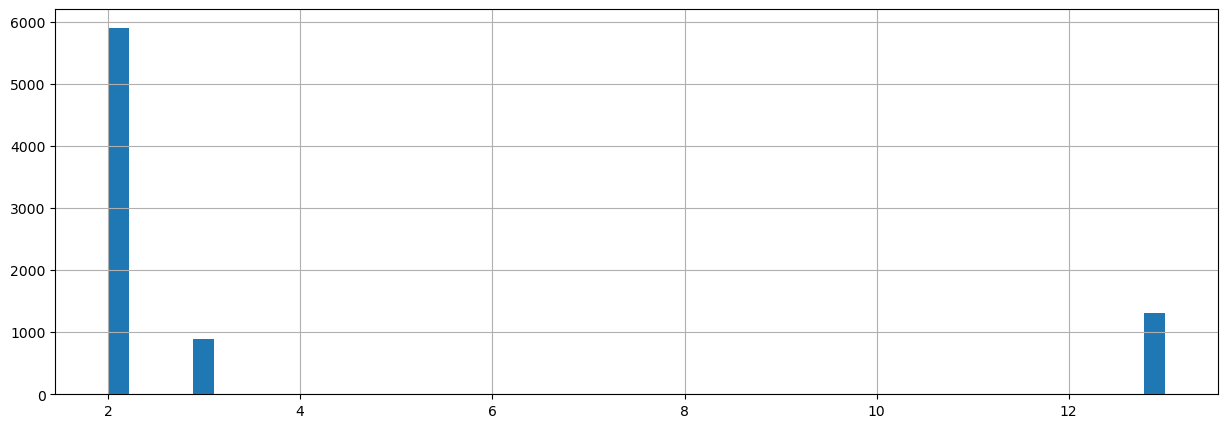

In [28]:
testset.language.hist(bins = 50, figsize = (15, 5))
plt.show()

In [29]:
value_counts = testset['language'].value_counts()
print(value_counts)

language
2     5906
13    1317
3      897
Name: count, dtype: int64


## Overview on label in each language

### Trainset

In [30]:
# filter out english, chinese and Indonesian
en_df = trainset[trainset.language ==2]
zh_df = trainset[trainset.language == 3]
id_df = trainset[trainset.language == 13]

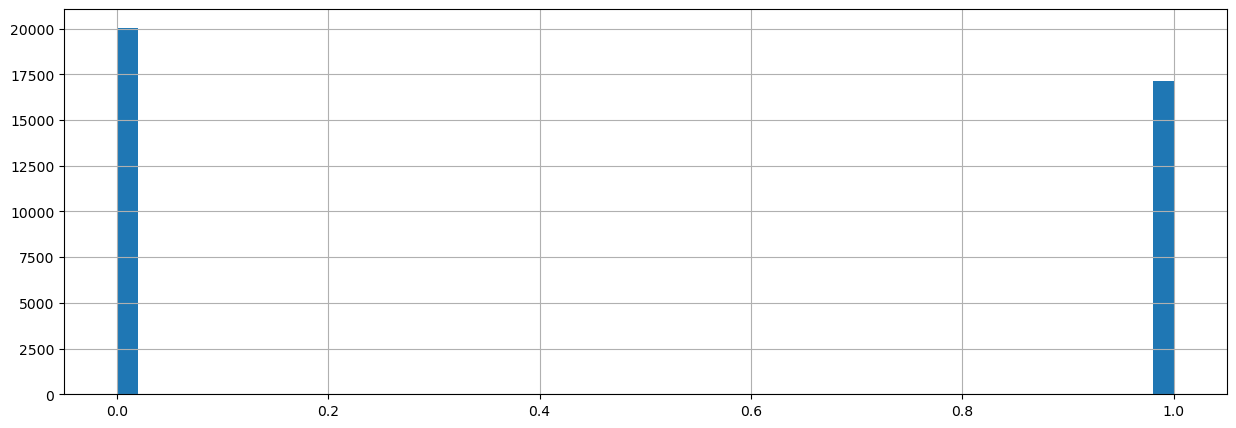

In [31]:
en_df.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [32]:
en_value_counts = en_df['label'].value_counts()
print(en_value_counts)

label
0.0    20054
1.0    17148
Name: count, dtype: int64


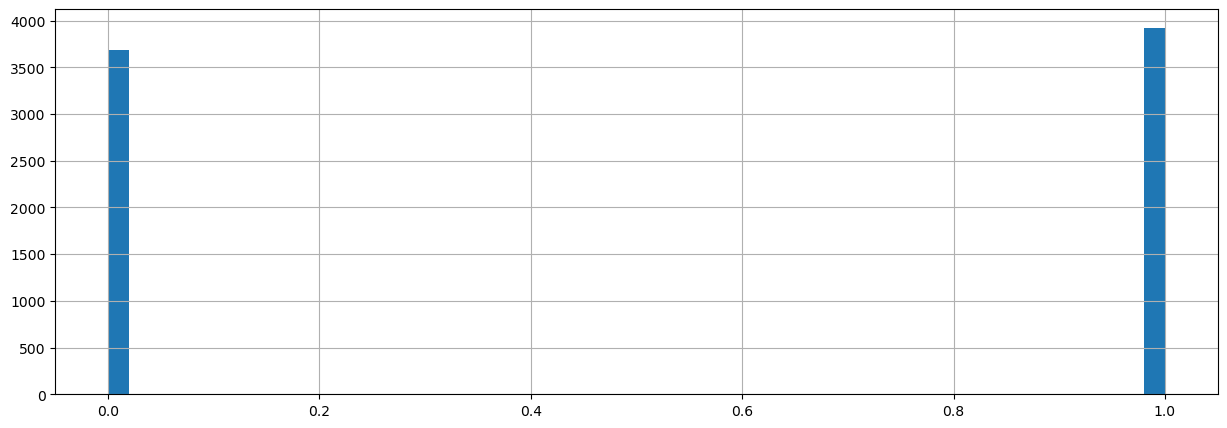

In [33]:
zh_df.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [34]:
zh_value_counts = zh_df['label'].value_counts()
print(zh_value_counts)

label
1.0    3926
0.0    3683
Name: count, dtype: int64


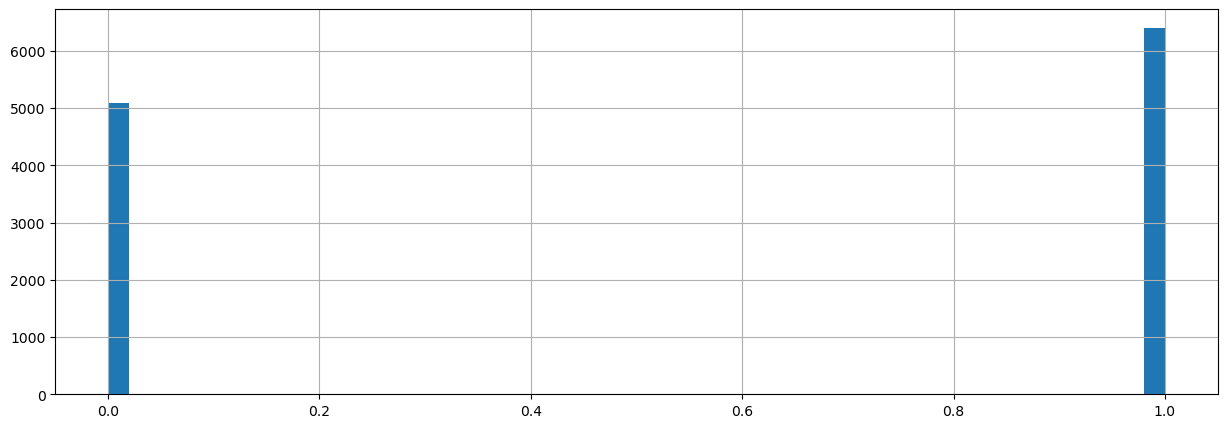

In [35]:
id_df.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [36]:
id_value_counts = id_df['label'].value_counts()
print(id_value_counts)

label
1.0    6408
0.0    5092
Name: count, dtype: int64


### Validation Set

In [37]:
# filter out english, chinese and Indonesian
en_df_val = val_set[val_set.language ==2]
zh_df_val = val_set[val_set.language == 3]
id_df_val = val_set[val_set.language == 13]

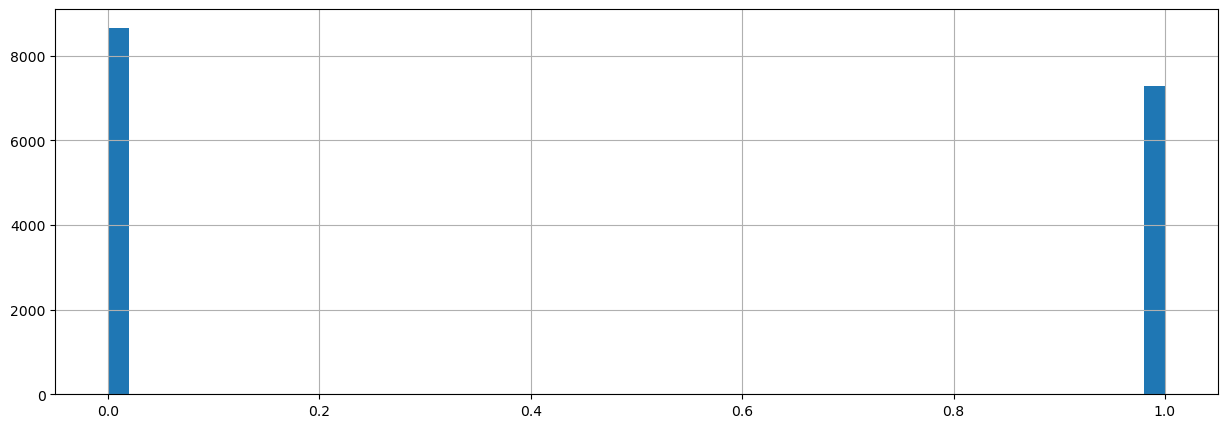

In [38]:
en_df_val.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [39]:
en_value_counts_val = en_df_val['label'].value_counts()
print(en_value_counts_val)

label
0.0    8666
1.0    7278
Name: count, dtype: int64


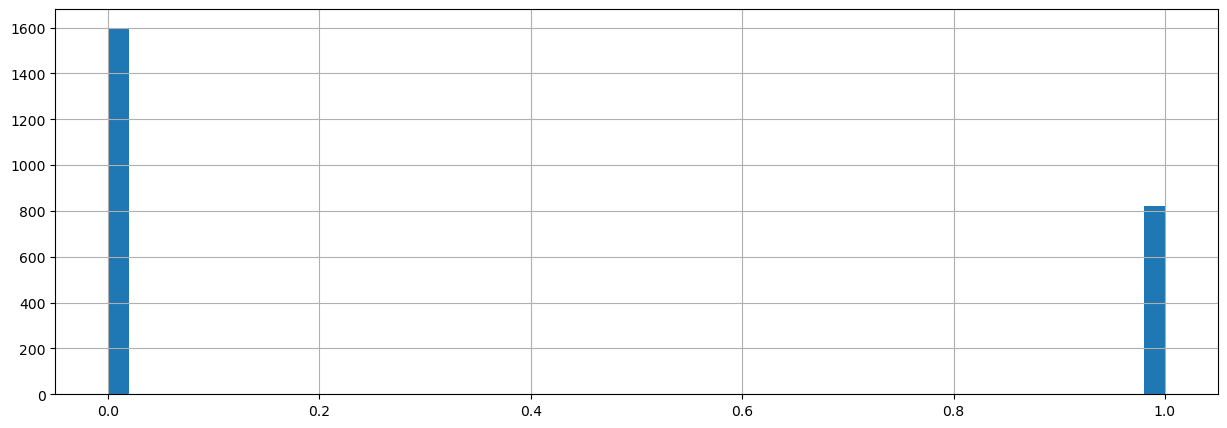

In [40]:
zh_df_val.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [41]:
zh_value_counts_val = zh_df_val['label'].value_counts()
print(zh_value_counts_val)

label
0.0    1600
1.0     820
Name: count, dtype: int64


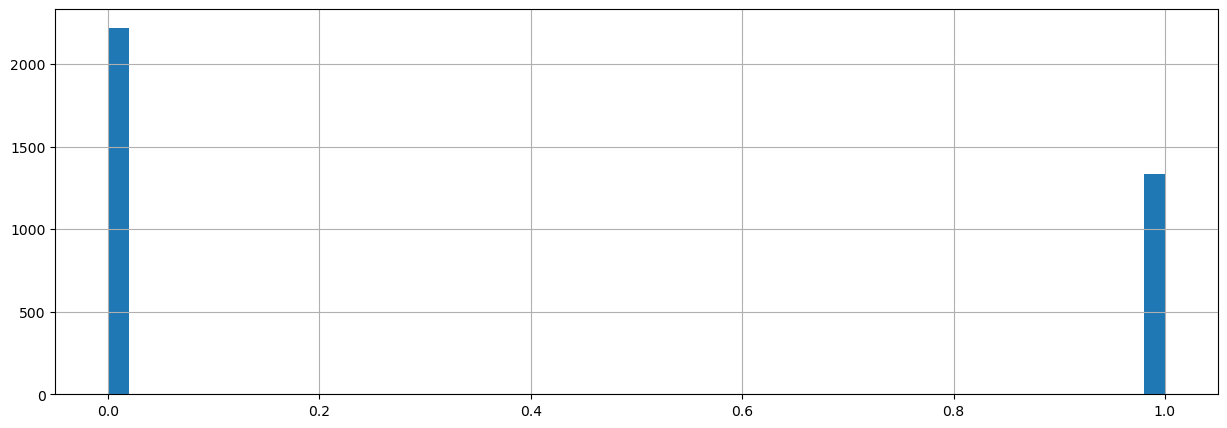

In [42]:
id_df_val.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [43]:
id_value_counts_val = id_df_val['label'].value_counts()
print(id_value_counts_val)

label
0.0    2221
1.0    1335
Name: count, dtype: int64


### Testset

In [44]:
# filter out english, chinese and Indonesian
en_df_test = testset[testset.language ==2]
zh_df_test = testset[testset.language == 3]
id_df_test = testset[testset.language == 13]

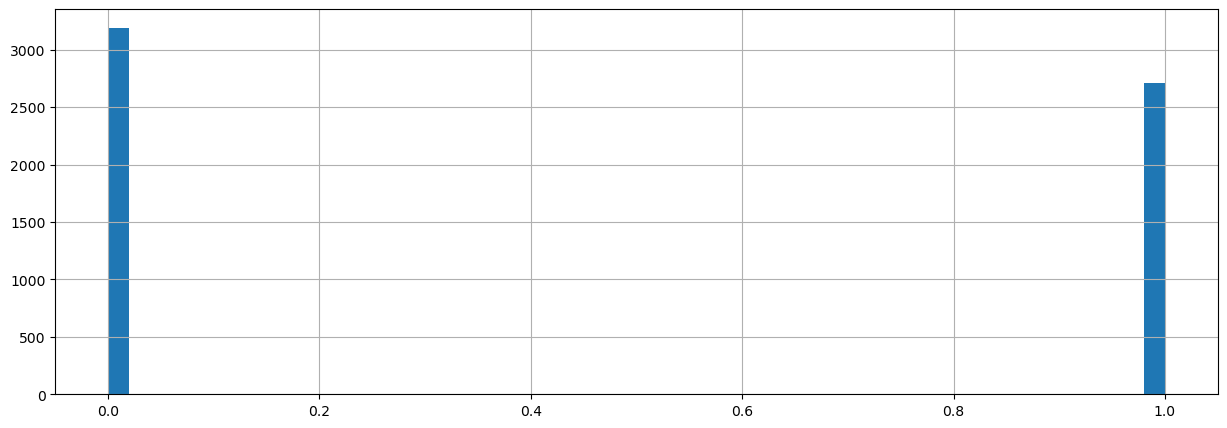

In [45]:
en_df_test.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [46]:
en_value_counts_test = en_df_test['label'].value_counts()
print(en_value_counts_test)

label
0.0    3192
1.0    2714
Name: count, dtype: int64


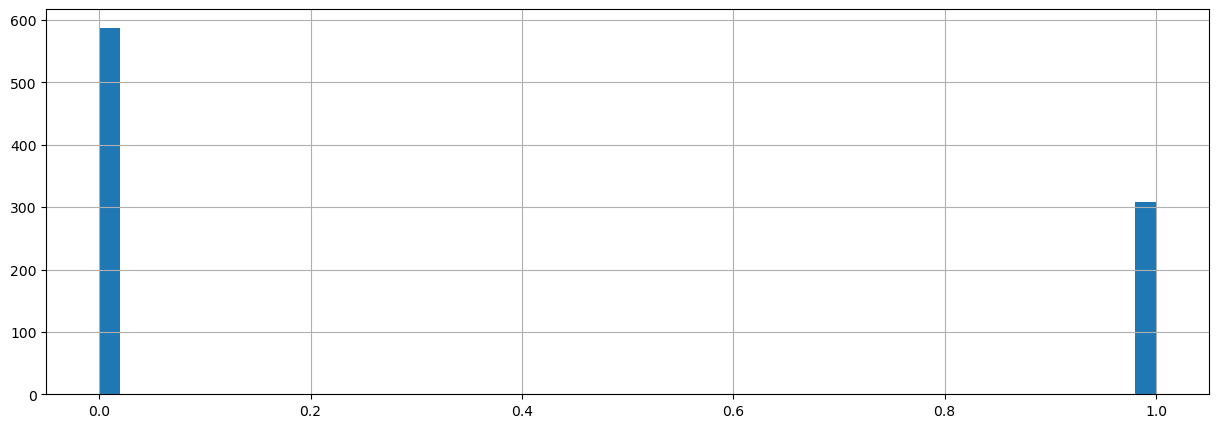

In [47]:
zh_df_test.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [48]:
zh_value_counts_test = zh_df_test['label'].value_counts()
print(zh_value_counts_test)

label
0.0    588
1.0    309
Name: count, dtype: int64


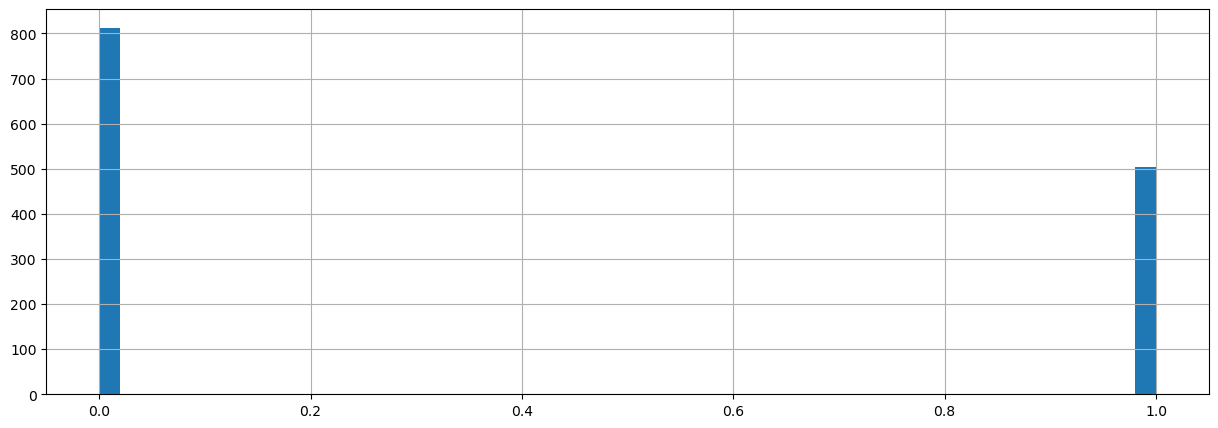

In [49]:
id_df_test.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [50]:
id_value_counts_test = id_df_test['label'].value_counts()
print(id_value_counts_test)

label
0.0    813
1.0    504
Name: count, dtype: int64


# Preprocessing

## Preprocessing English

In [51]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/maxine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/maxine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/maxine/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [52]:
# abbreviation list taken from https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing#Slangs
# English Abbreviation
abbreviations = {
    "$": " dollar ",
    "€": " euro ",
    "4ao": "for adults only",
    "a.m": "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "pls" : "please",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [53]:
class EnTextCleaner:
    def __init__(self, dataframe, abbreviations):
        self.dataframe = dataframe.copy()
        self.abbreviations = abbreviations

    def lower_casing(self):
        """Convert all text to lowercase."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe["text"].str.lower()
        return self
    
    def remove_urls(self):
        """Remove urls."""
        url_re = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe["cleaned_text"].apply(lambda text: url_re.sub('', text))
        return self
    
    def remove_usernames(self):
        """Remove usernames that start with '@'."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('@[^\s]+', '', text))
        return self

    def remove_html(self):
        """Remove HTML tags."""
        tag_re = re.compile(r'<[^>]+>')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: tag_re.sub('', text))
        return self

    def remove_hex_and_unicode(self):  #found in indonesian 
        """Remove hexadecimal and Unicode escape sequences."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(
            lambda text: re.sub(r'\\x[0-9a-fA-F]+|\\u[0-9a-fA-F]{4}', '', text))
        return self
    
    def remove_emoji(self):
        """Remove emoji from text"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: emoji.replace_emoji(text))
        return self
    
    def remove_punctuation(self):
        """Remove punctuation from the text, including Chinese punctuation if specified."""
        en_punct_pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: en_punct_pattern.sub('', text))
        return self
    
    def remove_numbers(self):
        """Remove numbers"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('\d+', '', text))
        return self
    
    def remove_whitespace(self):
        """Remove whitespaces"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: " ".join(text.split()))
        return self
    
    def tokenize(self, max_length=256):
        """Tokenize the text and truncate tokens if they exceed the max_length."""
        def tokenize_text(text):
            tokens = word_tokenize(text)
            if max_length is not None and len(tokens) > max_length:
                tokens = tokens[:max_length]
            return tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(tokenize_text)
        return self
    
    def chat_word_conversion(self):
        """Convert chat words into formal words"""
        def convert_abbrev(tokens):
            converted_tokens = [self.abbreviations.get(token.lower(), token) for token in tokens]
            return converted_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(convert_abbrev)
        return self
    
    def remove_en_stopwords(self):
        """Remove stopwords"""
        def remove_stopwords(tokens):
            english_stopwords = set(stopwords.words('english')) | {"retweet", "user"}
            removed_tokens = [token for token in tokens if token not in english_stopwords]
            return removed_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(remove_stopwords)
        return self
    
    def en_lemmatizer(self):
        """Lemmatize English"""
        
        def lemmatize_words(tokens):
            """Function to lemmatize words in a list of tokens"""
            lemmatizer = WordNetLemmatizer()
            wordnet_map = {
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV,
                'J': wordnet.ADJ
            }
            # Perform part-of-speech tagging
            pos_tagged_tokens = nltk.pos_tag(tokens)
            # Lemmatize each word based on its part-of-speech
            lemmatized_tokens = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_tokens]
            return lemmatized_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lemmatize_words)
        return self
    
    def get_cleaned_dataframe(self):
        """Return the cleaned DataFrame."""
        return self.dataframe

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\d'
/var/folders/1v/fzsl3_tx7tj_5mzdc45jw9r00000gn/T/ipykernel_4267/2081558408.py:19: SyntaxWarning: invalid escape sequence '\s'
  self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('@[^\s]+', '', text))
/var/folders/1v/fzsl3_tx7tj_5mzdc45jw9r00000gn/T/ipykernel_4267/2081558408.py:47: SyntaxWarning: invalid escape sequence '\d'
  self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('\d+', '', text))


## Chinese Preprocessing

In [54]:
# take from online and combine chatgpt generated stopwords
# https://www.ranks.nl/stopwords/chinese-stopwords
zh_stopwords = ['的','一','不','在','人','有','是','为','以','于','上','他','而','后','之','来','及','了',
                '因','下','可','到','由','这','与','也','此','但','并','个','其','已','无','小','我','们',
                '起','最','再','今','去','好','只','又','或','很','亦','某','把','那','你','乃','它','吧',
                '被','比','别','趁','当','从','得','打','凡','儿','尔','该','各','给','跟','和','何','还',
                '即','几','既','看','据','距','靠','啦','另','么','每','嘛','拿','哪','您','凭','且','却',
                '让','仍','啥','如','若','使','谁','虽','随','同','所','她','哇','嗡','往','些','向','沿',
                '哟','用','咱','则','怎','曾','至','致','着','诸','自','呢','吗','啊','哦','呀','噢','哈',
                '呃','嗯','唉','啦','呗','嘿','哒','啵','喽','嘛','咧','咋','哩','呼','吱','呜','咦','咚',
                '哐','咔','哧','咕','呶','噻','哇','哔','嗖','嘎','嗒','嘘','嘁','呕','啪','啷','啪','喳',
                '嘤','轰','哼','唿','嚯','呵','嚓','哒','嗡','嘻','嘟','嗑','嗬','嗔','嗦','嗝','嗄','嗯', 
                '嗨','喽','嘿','呀','呦','矣','哉','俺','尔','耶','呗','咻','咿','哎','哏','哗','咯','啰', 
                '啧','喏','喔','嗷','嘈','嘤','嗉','呷','呱','呤','噼','啪','叽','咣','咭','哒','嗒','嗤',
                '哙','哚','哜','嗖','嗑','嗲','嘚','嗌','嘧','嘭','哓','嗵','都']

In [55]:
class ZhTextCleaner:
    def __init__(self, dataframe, zh_stopwords):
        self.dataframe = dataframe.copy()
        self.zh_stopwords = zh_stopwords
    
    def remove_urls(self):
        """Remove urls."""
        url_re = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe["text"].apply(lambda text: url_re.sub('', text))
        return self
    
    def remove_usernames(self):
        """Remove usernames that start with '@'."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('@[^\s]+', '', text))
        return self

    def remove_html(self):
        """Remove HTML tags."""
        tag_re = re.compile(r'<[^>]+>')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: tag_re.sub('', text))
        return self

    def remove_hex_and_unicode(self):  #found in indonesian 
        """Remove hexadecimal and Unicode escape sequences."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(
            lambda text: re.sub(r'\\x[0-9a-fA-F]+|\\u[0-9a-fA-F]{4}', '', text))
        return self
    
    def remove_emoji(self):
        """Remove emoji from text"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: emoji.replace_emoji(text))
        return self
    
    def remove_punctuation(self):
        """Remove punctuation from the text, including Chinese punctuation if specified."""
        zh_punct_pattern = re.compile('[' + re.escape(string.punctuation) + "\u3000-\u303F" +"\uFF00-\uFFEF" +"\u2000-\u206F" +"\u2E00-\u2E7F" + ']+')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: zh_punct_pattern.sub('', text))
        return self
    
    def remove_numbers(self):
        """Remove numbers"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('\d+', '', text))
        return self
    
    def remove_whitespace(self):
        """Remove whitespaces"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: " ".join(text.split()))
        return self
    
    def tokenize(self, max_length=256):
        """Tokenize the text and truncate tokens if they exceed the max_length."""
        def tokenize_text(text):
            tokens = jieba.lcut(text)
            if max_length is not None and len(tokens) > max_length:
                tokens = tokens[:max_length]
            return tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(tokenize_text)
        return self
       
    def remove_zh_stopwords(self):
        """Remove stopwords"""
        def remove_stopwords(tokens):
            removed_tokens = [token for token in tokens if token not in self.zh_stopwords]
            return removed_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(remove_stopwords)
        return self
    
    def get_cleaned_dataframe(self):
        """Return the cleaned DataFrame."""
        return self.dataframe

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\d'
/var/folders/1v/fzsl3_tx7tj_5mzdc45jw9r00000gn/T/ipykernel_4267/3974997019.py:14: SyntaxWarning: invalid escape sequence '\s'
  self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('@[^\s]+', '', text))
/var/folders/1v/fzsl3_tx7tj_5mzdc45jw9r00000gn/T/ipykernel_4267/3974997019.py:42: SyntaxWarning: invalid escape sequence '\d'
  self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('\d+', '', text))


## Preprocessing Indosnesian

In [56]:
class IdTextCleaner:
    def __init__(self, dataframe, abbreviations):
        self.dataframe = dataframe.copy()
        self.abbreviations = abbreviations

    def lower_casing(self):
        """Convert all text to lowercase."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe["text"].str.lower()
        return self
    
    def remove_urls(self):
        """Remove urls."""
        url_re = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe["cleaned_text"].apply(lambda text: url_re.sub('', text))
        return self
    
    def remove_usernames(self):
        """Remove usernames that start with '@'."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('@[^\s]+', '', text))
        return self

    def remove_html(self):
        """Remove HTML tags."""
        tag_re = re.compile(r'<[^>]+>')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: tag_re.sub('', text))
        return self

    def remove_hex_and_unicode(self):  #found in indonesian 
        """Remove hexadecimal and Unicode escape sequences."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(
            lambda text: re.sub(r'\\x[0-9a-fA-F]+|\\u[0-9a-fA-F]{4}|[\u2600-\u26FF]', '', text))
        return self
    
    def remove_emoji(self):
        """Remove emoji from text"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: emoji.replace_emoji(text))
        return self
    
    def remove_punctuation(self):
        """Remove punctuation from the text, including Chinese punctuation if specified."""
        en_punct_pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: en_punct_pattern.sub('', text))
        return self
    
    def remove_numbers(self):
        """Remove numbers"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('\d+', '', text))
        return self
    
    def remove_whitespace(self):
        """Remove whitespaces"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: " ".join(text.split()))
        return self
    
    def tokenize(self, max_length=256):
        """Tokenize the text and truncate tokens if they exceed the max_length."""
        def tokenize_text(text):
            tokens = word_tokenize(text)
            if max_length is not None and len(tokens) > max_length:
                tokens = tokens[:max_length]
            return tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(tokenize_text)
        return self
    
    def chat_word_conversion(self):
        """Convert chat words into formal words"""
        def convert_abbrev(tokens):
            converted_tokens = [self.abbreviations.get(token.lower(), token) for token in tokens]
            return converted_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(convert_abbrev)
        return self
    
    def replace_slang(self):
        """Convert slang into formal words"""
        def replace_indonesian_slang(tokens):
            text = ' '.join(tokens)
            text_with_slang_replaced = replace_slang(text)
            replaced_tokens = text_with_slang_replaced.split()
            return replaced_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(replace_indonesian_slang)
        return self
    
    def remove_id_stopwords(self):
        """Remove stopwords"""
        def remove_stopwords(tokens):
            indonesian_stopwords = set(stopwords.words('indonesian')) | {"retweet", "user"}
            removed_tokens = [token for token in tokens if token not in indonesian_stopwords]
            return removed_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(remove_stopwords)
        return self
    
    def id_stemmer(self):
        """Stem indonesian text"""
        def stem_indonesian(tokens):
            stemmer_id = stemmer("indonesian")
            stemmed_tokens = [stemmer_id.stemWord(token) for token in tokens]
            return stemmed_tokens
        
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(stem_indonesian)
        return self
    
    def get_cleaned_dataframe(self):
        """Return the cleaned DataFrame."""
        return self.dataframe

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\d'
/var/folders/1v/fzsl3_tx7tj_5mzdc45jw9r00000gn/T/ipykernel_4267/2895787072.py:19: SyntaxWarning: invalid escape sequence '\s'
  self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('@[^\s]+', '', text))
/var/folders/1v/fzsl3_tx7tj_5mzdc45jw9r00000gn/T/ipykernel_4267/2895787072.py:47: SyntaxWarning: invalid escape sequence '\d'
  self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('\d+', '', text))


## Preprocessed Dataframe

In [57]:
def preprocessing(dataframe, abbreviations, zh_stopwords):
    
    # Split the dataframe base on its language
    en_df = dataframe[dataframe.language == 2]
    zh_df = dataframe[dataframe.language == 3]
    id_df = dataframe[dataframe.language == 13]
    
    #peform preprocessing for each language dataframe
    en_cleaner = EnTextCleaner(en_df, abbreviations)
    en_cleaner.lower_casing()
    en_cleaner.remove_urls()
    en_cleaner.remove_usernames()
    en_cleaner.remove_html()
    en_cleaner.remove_hex_and_unicode()
    en_cleaner.remove_emoji()
    en_cleaner.remove_punctuation()
    en_cleaner.remove_numbers()
    en_cleaner.remove_whitespace()
    en_cleaner.tokenize()
    en_cleaner.chat_word_conversion()
    en_cleaner.remove_en_stopwords()
    en_cleaner.en_lemmatizer()
    en_cleaned = en_cleaner.get_cleaned_dataframe()
    
    zh_cleaner = ZhTextCleaner(zh_df, zh_stopwords)
    zh_cleaner.remove_urls()
    zh_cleaner.remove_usernames()
    zh_cleaner.remove_html()
    zh_cleaner.remove_hex_and_unicode()
    zh_cleaner.remove_emoji()
    zh_cleaner.remove_punctuation()
    zh_cleaner.remove_numbers()
    zh_cleaner.remove_whitespace()
    zh_cleaner.tokenize()
    zh_cleaner.remove_zh_stopwords()
    zh_cleaned = zh_cleaner.get_cleaned_dataframe()
    
    id_cleaner = IdTextCleaner(id_df, abbreviations)
    id_cleaner.lower_casing()
    id_cleaner.remove_urls()
    id_cleaner.remove_usernames()
    id_cleaner.remove_html()
    id_cleaner.remove_hex_and_unicode()
    id_cleaner.remove_emoji()
    id_cleaner.remove_punctuation()
    id_cleaner.remove_numbers()
    id_cleaner.remove_whitespace()
    id_cleaner.tokenize()
    id_cleaner.chat_word_conversion()
    id_cleaner.replace_slang()
    id_cleaner.remove_id_stopwords()
    id_cleaner.id_stemmer()
    id_cleaned = id_cleaner.get_cleaned_dataframe()
    
    # Combine the cleaned subsets
    preprocessed_df = pd.concat([en_cleaned, zh_cleaned, id_cleaned], ignore_index=True)
    
    return preprocessed_df

## Preprocessed Trainset

In [58]:
preprocessed_trainset = preprocessing(trainset, abbreviations, zh_stopwords)
preprocessed_trainset

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1v/fzsl3_tx7tj_5mzdc45jw9r00000gn/T/jieba.cache
Loading model cost 0.447 seconds.
Prefix dict has been built successfully.


,text,label,language,cleaned_text
0,@m__isis ...,0.0,2,[]
1,"'How ISIS Brainwashed Me', an American Young G...",0.0,2,"[isi, brainwash, american, young, girl, speaks]"
2,Muslim Man Hugs ISIS Militant Armed Wearing Su...,0.0,2,"[muslim, man, hug, isi, militant, arm, wear, s..."
3,Le grand absent de l'euro a aura t daesh,0.0,2,"[le, grand, absent, de, leuro, aura, daesh]"
4,RT @joej2020usa: Netanyahu: Paris Massacre Sho...,1.0,2,"[netanyahu, paris, massacre, show, radical, is..."
...,...,...,...,...
56306,"PENGGUNA Sampaoli adalah sontoloyo, lebih memi...",1.0,13,"[guna, sampaol, sontoloyo, pilih, higuain, icard]"
56307,USER USER USER USER USER USER USER USER USER U...,1.0,13,"[eh, serius, pengin, muntah, banget, tahi, lo,..."
56308,Pengguna,1.0,13,[guna]
56309,OTAK KACANG.. DIKTATOR JOKOWI ADALAH TIKET HEB...,1.0,13,"[otak, kacang, ktator, jokow, tiket, hebat, ja..."


In [59]:
selected_texts = preprocessed_trainset.loc[preprocessed_trainset['language'] == 2, 'text']
print(selected_texts.iloc[26])
print("")
selected_texts = preprocessed_trainset.loc[preprocessed_trainset['language'] == 2, 'cleaned_text']
print(selected_texts.iloc[26])

RT @AyishaBaloch: #IndiaISISandBangladesh This nexus of Modi, Hasina and ISIS is the ugliest one against humanity pic.twitter.com/d477eyP9ug

['indiaisisandbangladesh', 'nexus', 'modi', 'hasina', 'isi', 'ugly', 'one', 'humanity', 'pictwittercomdeypug']


In [60]:
selected_texts = preprocessed_trainset.loc[preprocessed_trainset['language'] == 3, 'text']
print(selected_texts.iloc[26])
print("")
selected_texts = preprocessed_trainset.loc[preprocessed_trainset['language'] == 3, 'cleaned_text']
print(selected_texts.iloc[26])

: 叠猫猫的，400万场需要队友，不限级别，首页进，谢谢～  对方一个人

['叠', '猫猫', '万场', '需要', '队友', '限', '级别', '首页', '进', '谢谢', ' ', '对方', '一个']


In [61]:
selected_texts = preprocessed_trainset.loc[preprocessed_trainset['language'] == 13, 'text']
print(selected_texts.iloc[26])
print("")
selected_texts = preprocessed_trainset.loc[preprocessed_trainset['language'] == 13, 'cleaned_text']
print(selected_texts.iloc[26])

USER Untuk mengedukasi manusya2 udik seperti qm misalnya'

['edukasi', 'manusya', 'udik']


## Preprocessing Validation Set

In [62]:
preprocessed_valset = preprocessing(val_set, abbreviations, zh_stopwords)
preprocessed_valset

,text,label,language,cleaned_text
0,Massive explosion rocked Sadr city east #Baghd...,1.0,2,"[massive, explosion, rock, sadr, city, east, b..."
1,@user @user @user well didnt pay 1000$ phone 1...,1.0,2,"[well, didnt, pay, phone, st, world, mongoloid]"
2,RT @_______Krista: Vous n'avez pas peur de Die...,0.0,2,"[vous, navez, pas, peur, de, dieu, mais, vous,..."
3,RT @Nidalgazaui: Dozens of Shiite Hasd-Al-Shab...,1.0,2,"[dozen, shiite, hasdalshab, leader, kill, diya..."
4,@user see ferocity flames twat. indentificatio...,0.0,2,"[see, ferocity, flame, twat, indentification, ..."
...,...,...,...,...
21915,USER Gapapa sipit juga cantik aku mah \xf0\x9f...,0.0,13,"[gapapa, sipit, cantik, mah]"
21916,Koalisi tapi pakai hati. Cuci tangan sambil be...,0.0,13,"[koalisi, paka, hati, cuci, tangan, gandeng, t..."
21917,USER ke jamban ?',0.0,13,[jamban]
21918,USER Ngga ada kucing yang kesurupan karena kuc...,1.0,13,"[kucing, surup, kucing, setan]"


## Preprocessing Testset

In [63]:
preprocessed_testset = preprocessing(testset, abbreviations, zh_stopwords)
preprocessed_testset

,text,label,language,cleaned_text
0,RT @warreports: 8 Pakistanis of #IRGC 's Zeyna...,1.0,2,"[pakistani, irgc, zeynabiun, brigade, kill, no..."
1,gronk tide pod commercial retarded,1.0,2,"[gronk, tide, pod, commercial, retard]"
2,@sfrantzman @pmakela1 what they found in Syria...,0.0,2,"[find, syria, lot, weapon, wwii, gun, shop, is..."
3,After Pakistani Taliban announcement of their ...,0.0,2,"[pakistani, taliban, announcement, support, is..."
4,Good luck getting our attention this week ISIS...,0.0,2,"[good, luck, get, attention, week, isi, pokemo..."
...,...,...,...,...
8115,"Ajarkan Muslim, agama tak ngajarkan membunuh, ...",1.0,13,"[ajar, muslim, agama, ngajar, bunuh, paham, is..."
8116,"RT USER: Mainstream sdh jelas,bhw oposisi meng...",0.0,13,"[mainstream, jelasbhw, oposisi, esan, neger, m..."
8117,"Bismillah,; superiorPRINTING;; Harga; Ecer :LG...",0.0,13,"[bismil, superiorprinting, harga, ecer, lgnpol..."
8118,Nama Lengkap : Iris Jung\n\nNama Asli : Jung A...,0.0,13,"[nama, lengkap, iris, jungnnnama, asli, jung, ..."


# Export

In [64]:
preprocessed_trainset.to_pickle('preprocessed/preprocessed_trainset.pkl')
preprocessed_valset.to_pickle('preprocessed/preprocessed_valset.pkl')
preprocessed_testset.to_pickle('preprocessed/preprocessed_testset.pkl')
